In [78]:
#importing the required packages

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
nltk.download('stopwords')
from sklearn.metrics import precision_recall_fscore_support as score
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [79]:
#reading in the data with pandas library

df = pd.read_csv('/content/Reviews.csv', sep ='|')

**EXPLORATORY DATA ANALYSIS AND DATA CLEANING**

In [80]:
df.head()

,buyerName,buyerCountry,Evaluation,buyerFeedback,buyerProductFeedBack,buyerTranslationFeedback,downVoteCount,upVoteCount,evalData,evaluationId,responsiveness,warrantyService,functionality,status
0,L***a,BR,100,Foi uma ótima compra. Item de acordo com o des...,NaN,Was a great buy. Item according to the describ...,0,0,09 Apr 2024,60080995549271264,NaN,NaN,NaN,1
1,Щ***ч,RU,100,Товар соответствует описанию. Визуально все в ...,NaN,Item as described. Visually everything is norm...,0,0,23 Jan 2024,50109430005211774,NaN,NaN,NaN,1
2,L***R,BR,100,"Possui um bom matéria, corrente bem fina pense...",NaN,"It has a good matter, very thin chain I though...",2,0,16 Dec 2023,60077029346436454,NaN,NaN,NaN,1
3,A***a,MX,100,no lo he probado pero parece lo suficientement...,NaN,I haven't tried it but it seems good enough to...,0,0,01 Jan 2024,60078089203734379,NaN,NaN,NaN,1
4,v***r,UA,100,Замовлення було швидко доставлено в Київ через...,NaN,Bulo Shvidko was delivered to Kiev through the...,0,0,06 Apr 2024,30070787000237584,NaN,NaN,NaN,1


In [81]:
df.describe()

,Evaluation,buyerProductFeedBack,downVoteCount,upVoteCount,evaluationId,responsiveness,warrantyService,functionality,status
count,2000.000000,0.0,2000.000000,2000.00000,2.000000e+03,0.0,0.0,0.0,2000.0
mean,95.430000,NaN,0.084500,0.08050,4.303223e+16,NaN,NaN,NaN,1.0
std,13.557544,NaN,0.361144,0.43831,1.356860e+16,NaN,NaN,NaN,0.0
min,20.000000,NaN,0.000000,0.00000,2.004491e+16,NaN,NaN,NaN,1.0
25%,100.000000,NaN,0.000000,0.00000,3.006736e+16,NaN,NaN,NaN,1.0
50%,100.000000,NaN,0.000000,0.00000,3.007133e+16,NaN,NaN,NaN,1.0
75%,100.000000,NaN,0.000000,0.00000,6.007511e+16,NaN,NaN,NaN,1.0
max,100.000000,NaN,9.000000,10.00000,6.008124e+16,NaN,NaN,NaN,1.0


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   buyerName                 2000 non-null   object 
 1   buyerCountry              2000 non-null   object 
 2   Evaluation                2000 non-null   int64  
 3   buyerFeedback             670 non-null    object 
 4   buyerProductFeedBack      0 non-null      float64
 5   buyerTranslationFeedback  670 non-null    object 
 6   downVoteCount             2000 non-null   int64  
 7   upVoteCount               2000 non-null   int64  
 8   evalData                  2000 non-null   object 
 9   evaluationId              2000 non-null   int64  
 10  responsiveness            0 non-null      float64
 11  warrantyService           0 non-null      float64
 12  functionality             0 non-null      float64
 13  status                    2000 non-null   int64  
dtypes: float

In [83]:
df.dropna(axis=0, how = 'any', subset = ['buyerTranslationFeedback'], inplace=True)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 670 entries, 0 to 698
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   buyerName                 670 non-null    object 
 1   buyerCountry              670 non-null    object 
 2   Evaluation                670 non-null    int64  
 3   buyerFeedback             670 non-null    object 
 4   buyerProductFeedBack      0 non-null      float64
 5   buyerTranslationFeedback  670 non-null    object 
 6   downVoteCount             670 non-null    int64  
 7   upVoteCount               670 non-null    int64  
 8   evalData                  670 non-null    object 
 9   evaluationId              670 non-null    int64  
 10  responsiveness            0 non-null      float64
 11  warrantyService           0 non-null      float64
 12  functionality             0 non-null      float64
 13  status                    670 non-null    int64  
dtypes: float64(4), 

In [85]:
df.drop(axis = 1, columns = ['buyerName','buyerCountry','buyerFeedback','buyerProductFeedBack','evaluationId','responsiveness','downVoteCount','upVoteCount','evalData','warrantyService','functionality','status'], inplace = True)

In [86]:
df['reviews'] = df['buyerTranslationFeedback']
df.drop(columns = ['buyerTranslationFeedback'], axis = 1, inplace = True)

In [87]:
df.head()

,Evaluation,reviews
0,100,Was a great buy. Item according to the describ...
1,100,Item as described. Visually everything is norm...
2,100,"It has a good matter, very thin chain I though..."
3,100,I haven't tried it but it seems good enough to...
4,100,Bulo Shvidko was delivered to Kiev through the...


In [88]:
#defining a function to clean text, it will remove punctuations, tokenize the text and remove stopwords

def review_cleaner_string(text):
  text_nopunct = ''.join([char for char in text if char not in string.punctuation])
  text_tokenized = re.split('\W+', text_nopunct.lower())
  text_nostop = ' '.join([word for word in text_tokenized if word not in nltk.corpus.stopwords.words('english') or word == 'not'])

  #stemming words to reduce words to their base word.
  ps = nltk.PorterStemmer()
  text_stemmed = ' '.join([ps.stem(word) for word in text_nostop.split()])

  return text_stemmed


In [89]:
def review_cleaner_token(text):
  text_nopunct = ''.join([char for char in text if char not in string.punctuation])
  text_tokenized = re.split('\W+', text_nopunct.lower())
  text_nostop = [word for word in text_tokenized if word not in nltk.corpus.stopwords.words('english') or word == 'not']

  #stemming words to reduce words to their base word.
  ps = nltk.PorterStemmer()
  text_stemmed = [ps.stem(word) for word in text_nostop]

  return text_stemmed

In [90]:
#testing cleaning function on random string of characters

In [91]:
review_cleaner_string("hi, i'm not as bad as you think, running run runner")

'hi im not bad think run run runner'

In [92]:
review_cleaner_token("hi, i'm not as bad as you think, running run runner")

['hi', 'im', 'not', 'bad', 'think', 'run', 'run', 'runner']

In [93]:
#applying the function to the reviews
df['stemmed_reviews'] = df['reviews'].apply(lambda x: review_cleaner_string(x))

In [94]:
#applying the function to the reviews
df['stemmed_reviews_tokens'] = df['reviews'].apply(lambda x: review_cleaner_token(x))

In [95]:
df.head()

,Evaluation,reviews,stemmed_reviews,stemmed_reviews_tokens
0,100,Was a great buy. Item according to the describ...,great buy item accord describ ad im satisfi re...,"[great, buy, item, accord, describ, ad, im, sa..."
1,100,Item as described. Visually everything is norm...,item describ visual everyth normal good chain ...,"[item, describ, visual, everyth, normal, good,..."
2,100,"It has a good matter, very thin chain I though...",good matter thin chain thought thicker need te...,"[good, matter, thin, chain, thought, thicker, ..."
3,100,I haven't tried it but it seems good enough to...,havent tri seem good enough cut wood hurri rec...,"[havent, tri, seem, good, enough, cut, wood, h..."
4,100,Bulo Shvidko was delivered to Kiev through the...,bulo shvidko deliv kiev misstekspr didnt get r...,"[bulo, shvidko, deliv, kiev, misstekspr, didnt..."


In [96]:
#feature engineering

In [97]:
df['Evaluation'] = df['Evaluation']/20

In [98]:
df['Evaluation'].unique()

array([5., 4., 3., 2., 1.])

In [99]:
df['Evaluation'] = df['Evaluation'].astype(int)

In [100]:
def polarize(x):
  if x > 3:
    return 'positive'
  elif x == 3:
    return 'neutral'
  else:
    return 'negative'


In [101]:
df['polarity'] = df['Evaluation'].apply(lambda x: polarize(x))

In [102]:
df['polarity'].unique()

array(['positive', 'neutral', 'negative'], dtype=object)

In [103]:
df.head()

,Evaluation,reviews,stemmed_reviews,stemmed_reviews_tokens,polarity
0,5,Was a great buy. Item according to the describ...,great buy item accord describ ad im satisfi re...,"[great, buy, item, accord, describ, ad, im, sa...",positive
1,5,Item as described. Visually everything is norm...,item describ visual everyth normal good chain ...,"[item, describ, visual, everyth, normal, good,...",positive
2,5,"It has a good matter, very thin chain I though...",good matter thin chain thought thicker need te...,"[good, matter, thin, chain, thought, thicker, ...",positive
3,5,I haven't tried it but it seems good enough to...,havent tri seem good enough cut wood hurri rec...,"[havent, tri, seem, good, enough, cut, wood, h...",positive
4,5,Bulo Shvidko was delivered to Kiev through the...,bulo shvidko deliv kiev misstekspr didnt get r...,"[bulo, shvidko, deliv, kiev, misstekspr, didnt...",positive


[Text(0.5, 1.0, 'No of Reviews for each Polarity Rating')]

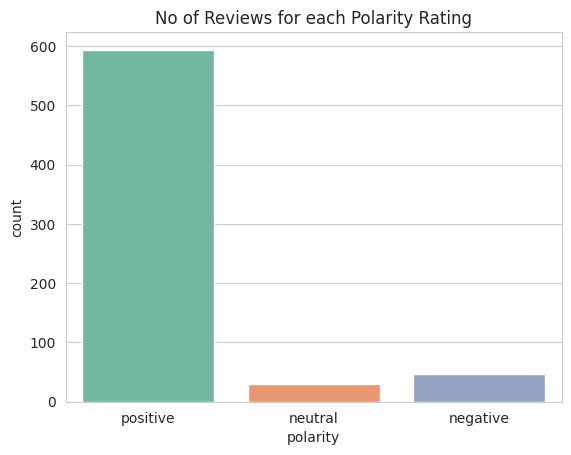

In [104]:
#data visualization

sns.countplot(df, x = 'polarity', palette = 'Set2').set(title = 'No of Reviews for each Polarity Rating')

In [105]:
df.drop(columns = ['Evaluation', 'reviews'], axis = 1, inplace = True)

In [106]:
df.head()

,stemmed_reviews,stemmed_reviews_tokens,polarity
0,great buy item accord describ ad im satisfi re...,"[great, buy, item, accord, describ, ad, im, sa...",positive
1,item describ visual everyth normal good chain ...,"[item, describ, visual, everyth, normal, good,...",positive
2,good matter thin chain thought thicker need te...,"[good, matter, thin, chain, thought, thicker, ...",positive
3,havent tri seem good enough cut wood hurri rec...,"[havent, tri, seem, good, enough, cut, wood, h...",positive
4,bulo shvidko deliv kiev misstekspr didnt get r...,"[bulo, shvidko, deliv, kiev, misstekspr, didnt...",positive


great buy item accord describ ad im satisfi recommend item describ visual everyth normal good chain strong handl good matter thin chain thought thicker need test v realli cut rest satisfactori havent tri seem good enough cut wood hurri recommend bulo shvidko deliv kiev misstekspr didnt get recommend sell work thick branch still dont tri thick log seem approx small packag handi came quickli recommend interest thing well pack thinner chain chainsaw 17 discount excel test seem good qualiti congratul seller agil shipment product great case attach belt threw carmayb come handi that miss tri conveni certain case not bad like qualiti sane dragon cover look good qualiti tri arriv well protect receiv manual mini saw case dimens small compact appear high qualiti sharpen not test yet ok per descript arriv 13 day multipl order uniqu photographi manual chain saw want use dont know still look durabl thread saw bought guy think bought well use surviv corner room disast prepar look solid includ nice b

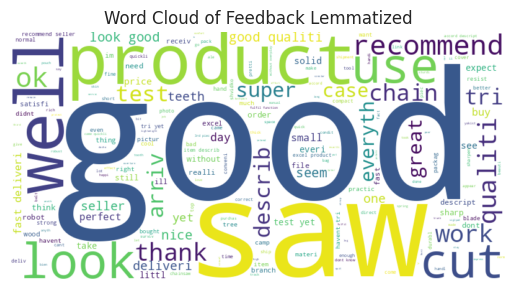

In [107]:
from wordcloud import WordCloud

# Flatten the list of word lists into a single list of words
all_stemmed = ' '.join([word for word in df['stemmed_reviews']])
print(all_stemmed)

# Join the words into a single string

#Create a word cloud from the lemmas
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_stemmed)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Feedback Lemmatized')
plt.show()

In [108]:
counti = len(df.loc[df['polarity']== 'positive'])
counti

594

In [109]:
df_positive = df.loc[df['polarity']== 'positive'].sample(594, replace=False)
df_neutral = df.loc[df['polarity']== 'neutral']
df_negative = df.loc[df['polarity']== 'negative']

In [110]:
df_neutral = df.loc[df['polarity']== 'neutral'].sample(594, replace=True)
df_negative = df.loc[df['polarity']== 'negative'].sample(594, replace=True)


In [111]:
df = pd.concat([df_positive, df_neutral, df_negative])

In [112]:
df.head()

,stemmed_reviews,stemmed_reviews_tokens,polarity
617,work sometim get trunk take strength abl remov,"[work, sometim, get, trunk, take, strength, ab...",positive
275,robot without tri class,"[robot, without, tri, class]",positive
151,pilingalreadi thyr shine,"[pilingalreadi, thyr, shine]",positive
672,great saw tri summer friend bought would like ...,"[great, saw, tri, summer, friend, bought, woul...",positive
312,appar look good qualiti,"[appar, look, good, qualiti]",positive


In [113]:
# Do encoding for Polarity ratings
df.loc[df['polarity']== 'negative', 'polarity'] = 0
df.loc[df['polarity']== 'neutral', 'polarity'] = 1
df.loc[df['polarity']== 'positive', 'polarity'] = 2

In [114]:
# convert the datatype of Polarity_Rating to integer
df['polarity'] = df['polarity'].astype('int64')

In [115]:
df

,stemmed_reviews,stemmed_reviews_tokens,polarity
617,work sometim get trunk take strength abl remov,"[work, sometim, get, trunk, take, strength, ab...",2
275,robot without tri class,"[robot, without, tri, class]",2
151,pilingalreadi thyr shine,"[pilingalreadi, thyr, shine]",2
672,great saw tri summer friend bought would like ...,"[great, saw, tri, summer, friend, bought, woul...",2
312,appar look good qualiti,"[appar, look, good, qualiti]",2
...,...,...,...
299,chines cheesi,"[chines, cheesi]",0
250,not cut well,"[not, cut, well]",0
259,not deliv torvar not give seller not reject,"[not, deliv, torvar, not, give, seller, not, r...",0
262,not arriv,"[not, arriv]",0


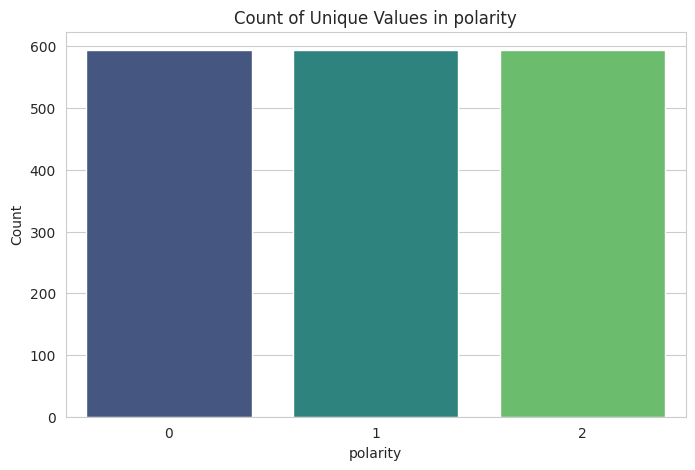

In [116]:
plt.figure(figsize=(8, 5))  # Set figure size
sns.countplot(data=df, x='polarity', palette='viridis')  # Countplot
plt.title('Count of Unique Values in polarity')  # Title
plt.xlabel('polarity')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.show()

In [117]:
X = df['stemmed_reviews_tokens']
y = df["polarity"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
, stratify = y)

In [118]:
tfidf_vect = TfidfVectorizer(analyzer = review_cleaner_token)
tfidf_vect_fit = tfidf_vect.fit(X_train)
Train_X_Tfidf = tfidf_vect_fit.transform(X_train)
Test_X_Tfidf = tfidf_vect_fit.transform(X_test)


In [119]:
#converting sparse matrix to a dataframe

In [120]:
pd.DataFrame(Train_X_Tfidf.toarray()).reset_index(drop=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [121]:
# Build a random forest model
import time

In [122]:
rf = RandomForestClassifier(n_estimators = 50, max_depth= 20, n_jobs= -1,  random_state = 42)


In [123]:
start_time = time.time()
rf_model = rf.fit(Train_X_Tfidf, y_train)
end_time = time.time()
fit_time = (end_time - start_time)

In [124]:
# sorted(zip(rf_model.feature_importances_), reverse = True)[0:10]

In [125]:
start_time = time.time()
y_pred = rf_model.predict(Test_X_Tfidf)
end_time = time.time()
pred_time = (end_time - start_time)

In [126]:
precision, recall, fscore, support = score(y_test, y_pred, pos_label=2, average='weighted')

In [127]:
print('fit_time: {}/ pred_time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(round(fit_time, 3),
                                                                                          round(pred_time, 3),
                                                                                          round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred==y_test).sum() / len(y_pred), 3)))

fit_time: 0.175/ pred_time: 0.028 ---- Precision: 0.917 / Recall: 0.908 / Accuracy: 0.908


In [128]:
from sklearn.ensemble import GradientBoostingClassifier

In [129]:
gb = GradientBoostingClassifier(n_estimators=150, max_depth=11, learning_rate = 0.1)

start_time = time.time()
gb_model = gb.fit(Train_X_Tfidf, y_train)
end_time = time.time()
fit_time = (end_time - start_time)

In [130]:
start_time = time.time()
y_pred_gb = gb_model.predict(Test_X_Tfidf)
end_time = time.time()
pred_time = (end_time - start_time)

In [131]:
precision, recall, fscore, support = score(y_test, y_pred_gb, pos_label=2, average='weighted')

In [132]:
print('fit_time: {}/ pred_time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(round(fit_time, 3),
                                                                                          round(pred_time, 3),
                                                                                          round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred_gb==y_test).sum() / len(y_pred), 3)))

fit_time: 1.962/ pred_time: 0.013 ---- Precision: 0.947 / Recall: 0.941 / Accuracy: 0.941


In [133]:
from sklearn.model_selection import GridSearchCV

In [134]:
#building a custom grid search

In [135]:
rf = RandomForestClassifier()
param = {'n_estimators': [10, 150, 300],
         'max_depth': [10, 20, 30, 60, 90, None]}

In [136]:
gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(Train_X_Tfidf, y_train)

In [137]:
cv = pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

In [138]:
cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.068857,0.002416,0.004800,0.000217,90,10,"{'max_depth': 90, 'n_estimators': 10}",0.936842,0.947368,0.940351,0.940351,0.947368,0.942456,0.004211,1
17,2.185540,0.044059,0.078703,0.003945,None,300,"{'max_depth': None, 'n_estimators': 300}",0.936842,0.947368,0.940351,0.936842,0.947368,0.941754,0.004760,2
16,1.052309,0.013331,0.039076,0.001090,None,150,"{'max_depth': None, 'n_estimators': 150}",0.936842,0.947368,0.940351,0.936842,0.947368,0.941754,0.004760,2
15,0.071257,0.001854,0.004801,0.000138,None,10,"{'max_depth': None, 'n_estimators': 10}",0.936842,0.936842,0.940351,0.936842,0.947368,0.939649,0.004092,4
14,2.730178,0.773628,0.080895,0.026696,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.936842,0.936842,0.940351,0.936842,0.947368,0.939649,0.004092,4


In [139]:
def train_RF(n_est, depth):
  rf = RandomForestClassifier(n_estimators = n_est, max_depth= depth, n_jobs= -1,  random_state = 42)
  rf_model = rf.fit(Train_X_Tfidf, y_train)
  y_pred = rf_model.predict(Test_X_Tfidf)
  precision, recall, fscore, support = score(y_test, y_pred, pos_label=2, average='weighted')
  print('Est: {}/ Depth: {} ----Precision: {} / Recall: {} / Accuracy: {}'.format(n_est, depth, round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred==y_test).sum() / len(y_pred), 3)))

In [140]:
for n_est in [10, 50, 100]:
  for depth in [10, 20, 30, None]:
    train_RF(n_est, depth)

Est: 10/ Depth: 10 ----Precision: 0.841 / Recall: 0.812 / Accuracy: 0.812
Est: 10/ Depth: 20 ----Precision: 0.85 / Recall: 0.815 / Accuracy: 0.815
Est: 10/ Depth: 30 ----Precision: 0.868 / Recall: 0.846 / Accuracy: 0.846
Est: 10/ Depth: None ----Precision: 0.947 / Recall: 0.941 / Accuracy: 0.941
Est: 50/ Depth: 10 ----Precision: 0.904 / Recall: 0.888 / Accuracy: 0.888
Est: 50/ Depth: 20 ----Precision: 0.917 / Recall: 0.908 / Accuracy: 0.908
Est: 50/ Depth: 30 ----Precision: 0.907 / Recall: 0.902 / Accuracy: 0.902
Est: 50/ Depth: None ----Precision: 0.947 / Recall: 0.941 / Accuracy: 0.941
Est: 100/ Depth: 10 ----Precision: 0.893 / Recall: 0.871 / Accuracy: 0.871
Est: 100/ Depth: 20 ----Precision: 0.923 / Recall: 0.916 / Accuracy: 0.916
Est: 100/ Depth: 30 ----Precision: 0.912 / Recall: 0.908 / Accuracy: 0.908
Est: 100/ Depth: None ----Precision: 0.947 / Recall: 0.941 / Accuracy: 0.941


In [141]:
def train_GB(est, max_depth, lr):
  gb = GradientBoostingClassifier(n_estimators=est, max_depth=max_depth, learning_rate = lr)
  gb_model = gb.fit(Train_X_Tfidf, y_train)
  y_pred_gb = gb_model.predict(Test_X_Tfidf)
  precision, recall, fscore, support = score(y_test, y_pred_gb, pos_label=2, average='weighted')
  print('Est: {}/ Depth: {}/ LR: {} ----Precision: {} / Recall: {} / Accuracy: {}'.format(est, max_depth, lr, round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred_gb==y_test).sum() / len(y_pred), 3)))

In [142]:
for n_est in [50, 100, 150]:
  for max_depth in [3, 7, 11, 15]:
    for lr in [0.01, 0.1, 1]:
      train_GB(n_est, max_depth, lr)

Est: 50/ Depth: 3/ LR: 0.01 ----Precision: 0.666 / Recall: 0.529 / Accuracy: 0.529
Est: 50/ Depth: 3/ LR: 0.1 ----Precision: 0.889 / Recall: 0.882 / Accuracy: 0.882
Est: 50/ Depth: 3/ LR: 1 ----Precision: 0.947 / Recall: 0.941 / Accuracy: 0.941
Est: 50/ Depth: 7/ LR: 0.01 ----Precision: 0.737 / Recall: 0.641 / Accuracy: 0.641
Est: 50/ Depth: 7/ LR: 0.1 ----Precision: 0.947 / Recall: 0.947 / Accuracy: 0.947
Est: 50/ Depth: 7/ LR: 1 ----Precision: 0.947 / Recall: 0.941 / Accuracy: 0.941
Est: 50/ Depth: 11/ LR: 0.01 ----Precision: 0.799 / Recall: 0.737 / Accuracy: 0.737
Est: 50/ Depth: 11/ LR: 0.1 ----Precision: 0.947 / Recall: 0.947 / Accuracy: 0.947
Est: 50/ Depth: 11/ LR: 1 ----Precision: 0.947 / Recall: 0.941 / Accuracy: 0.941
Est: 50/ Depth: 15/ LR: 0.01 ----Precision: 0.828 / Recall: 0.773 / Accuracy: 0.773
Est: 50/ Depth: 15/ LR: 0.1 ----Precision: 0.937 / Recall: 0.933 / Accuracy: 0.933
Est: 50/ Depth: 15/ LR: 1 ----Precision: 0.947 / Recall: 0.941 / Accuracy: 0.941
Est: 100/ Dept

In [143]:
#df = pd.read_csv('/content/grid_search_rf.csv', sep =',')

In [144]:
#df

In [145]:
#df_gb = pd.read_csv('/content/grid_search_gb.csv', sep =',')

In [146]:
#df_gb

In [147]:
from sklearn.metrics import confusion_matrix

In [148]:
y_true = np.array(y_test)
y_pred = np.array(y_pred_gb)

In [149]:
cm = confusion_matrix(y_true, y_pred)

In [150]:
cm

array([[117,   2,   0],
       [  3, 116,   0],
       [  0,  16, 103]])

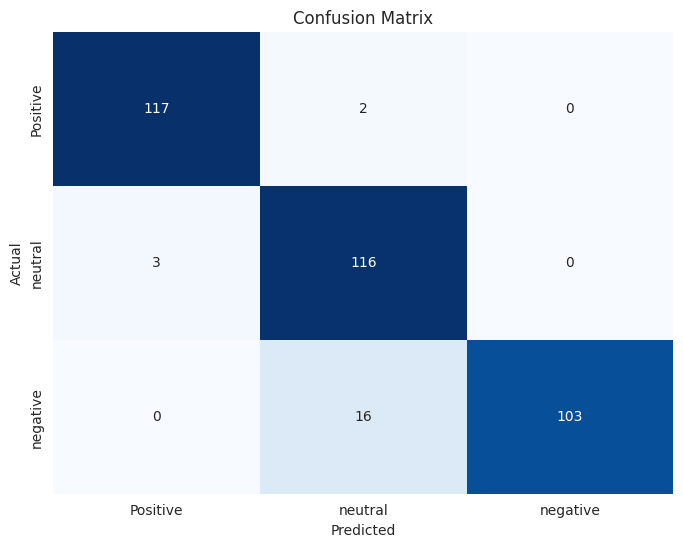

In [151]:
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Positive', 'neutral', 'negative'],
            yticklabels=['Positive', 'neutral', 'negative'])

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Show the plot
plt.show()